In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Task3") \
    .getOrCreate()

In [4]:
#load dataset from hdfs
df=spark.read.option("header", True).csv('hdfs://localhost:9000/input/india-news-headlines.csv')
# De-weight the entire DataFrame
df_distinct = df.dropDuplicates()
# Convert to rdd
news_rdd = df_distinct.rdd

# 1. Press releases top 10 years Visualisation

In [5]:
#use rdd map method to convert dataset
news_year_rdd = news_rdd.map(lambda row: (row[0][:4],1))
news_year_count_rdd=news_year_rdd.reduceByKey(lambda a,b:a+b)
# Sorting RDDs by sortBy and descending by count
news_year_count_rdd = news_year_count_rdd.sortBy(lambda x: x[1], ascending=False).take(10)
# Converts an RDD to a DataFrame and specifies the column names
news_year_top_10 = spark.createDataFrame(news_year_count_rdd, ["Year", "Count"])
# Show DataFrame
news_year_top_10.show(10)

+----+------+
|Year| Count|
+----+------+
|2016|254168|
|2018|253294|
|2014|253240|
|2013|253098|
|2015|252966|
|2012|252915|
|2017|251375|
|2011|240784|
|2009|203990|
|2020|182087|
+----+------+



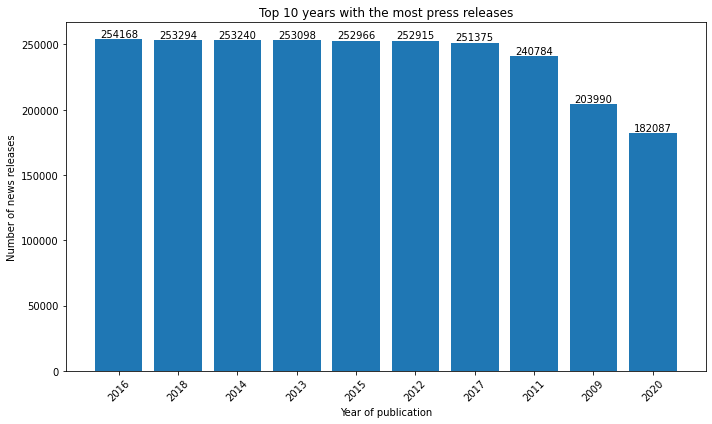

In [6]:
# Converting a DataFrame to a Pandas DataFrame
plt_df = pd.DataFrame(news_year_count_rdd, columns=["Year", "Count"])
# Plotting bar charts
plt.figure(figsize=(10, 6))
bars = plt.bar(plt_df["Year"], plt_df["Count"])
plt.xlabel("Year of publication")
plt.ylabel("Number of news releases")
plt.title("Top 10 years with the most press releases")
plt.xticks(rotation=45)
plt.tight_layout()

# Add numbers to each column
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

#show plt 
plt.show()

# 2. Visualisation of word frequencies in news categories

In [7]:
# Defining a list of deactivated words
stopwords = set(["the", "is", "in", "at", "which", "on", "and", "a", "to", "of"]) 

In [11]:
 #Filtering specific categories of data
filter_category = "history"   
filter_category_rdd = news_rdd.filter(lambda row: row[1] == filter_category)
# Extracting words from headings using flatMap
flatMap_rdd = filter_category_rdd.flatMap(lambda row: [(row[1], word) for word in row[2].split()])
# Filter out stop words
flatMap_rdd = flatMap_rdd.filter(lambda x: x[1].lower() not in stopwords)
# Count the word frequency of each word
word_count_rdd = flatMap_rdd.map(lambda x: (x[1], 1)).reduceByKey(lambda a, b: a + b)
# Get the top 10 words with the most occurrences
top_10_words = word_count_rdd.sortBy(lambda x: x[1], ascending=False).take(10)
# Converts an RDD to a DataFrame and specifies the column names
top_10_words_df = spark.createDataFrame(top_10_words, ["word", "count"])
# Show DataFrame
top_10_words_df.show(10)

+--------+------------+
|category|        word|
+--------+------------+
| history|        1930|
| history|    Hamilton|
| history|     British|
| history|      Empire|
| history|       Games|
| history|        1958|
| history|     Cardiff|
| history|     British|
| history|      Empire|
| history|Commonwealth|
+--------+------------+
only showing top 10 rows



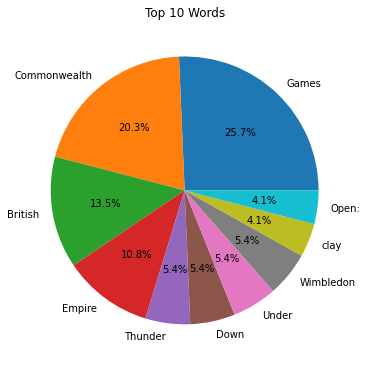

In [13]:
# Getting words and counts from a DataFrame
top_10_words_pd = pd.DataFrame(top_10_words_df.collect(), columns=["word", "count"])
words = top_10_words_pd["word"].tolist()
counts = top_10_words_pd["count"].tolist()
# Create pie charts
plt.figure(figsize=(6, 8))
plt.pie(counts, labels=words, autopct='%1.1f%%')
plt.title("Top 10 Words")
# Show charts
plt.show()